In [1]:
%config InlineBackend.figure_format = 'retina'
#import jax.tools.colab_tpu
#jax.tools.colab_tpu.setup_tpu()
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split

from jax import random
from eprop.dataset import Sinusoids
from eprop.utils import initialize_parameters, mse_loss
from eprop.eprop import LSNN

In [2]:
####
# Parameters
####
seed = 42
epochs = 100
n_inp = 100
n_rec = 100
n_out = 1
tau_rec = 30e-3
tau_out = 30e-3
thr = 0.1
gamma = 0.3
lr_inp = 3e-4
lr_rec = 5e-4
lr_out = 9e-4
n_t = 1000
reg =1e-4
f0 = 5
w_gain = 0.01
dt = 1e-3

# Deterministic JAX 
key = random.PRNGKey(seed)

# Create dataset
sinusoid_dataset = Sinusoids(seed, seq_length=n_t, num_samples=5, num_inputs=n_inp, input_freq=50)
train_size   = int(len(sinusoid_dataset) * 0.5)
train_set, _ = random_split(sinusoid_dataset, [train_size, len(sinusoid_dataset)-train_size])
train_data   = DataLoader(train_set, 1, shuffle=True)

theta = initialize_parameters(key, n_inp, n_rec, n_out, w_gain)

lsnn =  LSNN(n_inp, n_rec, n_out, tau_rec, tau_out, thr,
             gamma, lr_inp, lr_rec, lr_out, n_t, reg, f0, dt)

loss_arr = []
fr_arr   = []
for epoch in range(epochs):
    for _, (x, y) in enumerate(train_data):
        x = np.array(onp.array(x.squeeze(0)))        
        y = np.array(onp.array(y.permute(1,0)))
        
        yhat, traces, reg_term = lsnn.forward(theta, x)
        loss   = yhat-y # Going with the derivative of (yhat-y)^2
        grads  = lsnn.acc_gradient(loss, traces, reg_term, theta)
        theta  = lsnn.upd_weights(theta, grads)
        loss_arr.append(mse_loss(yhat,y))
        
    if epoch%10 == 0:
        print(f'Epoch: [{epoch}/{epochs}] - MSE Loss: {mse_loss(yhat, y):.4f}')

Epoch: [0/100] - MSE Loss: 0.1859
Epoch: [10/100] - MSE Loss: 0.0939
Epoch: [20/100] - MSE Loss: 0.1489
Epoch: [30/100] - MSE Loss: 0.0559
Epoch: [40/100] - MSE Loss: 0.0334
Epoch: [50/100] - MSE Loss: 0.0531
Epoch: [60/100] - MSE Loss: 0.0502
Epoch: [70/100] - MSE Loss: 0.0219
Epoch: [80/100] - MSE Loss: 0.0144
Epoch: [90/100] - MSE Loss: 0.0155


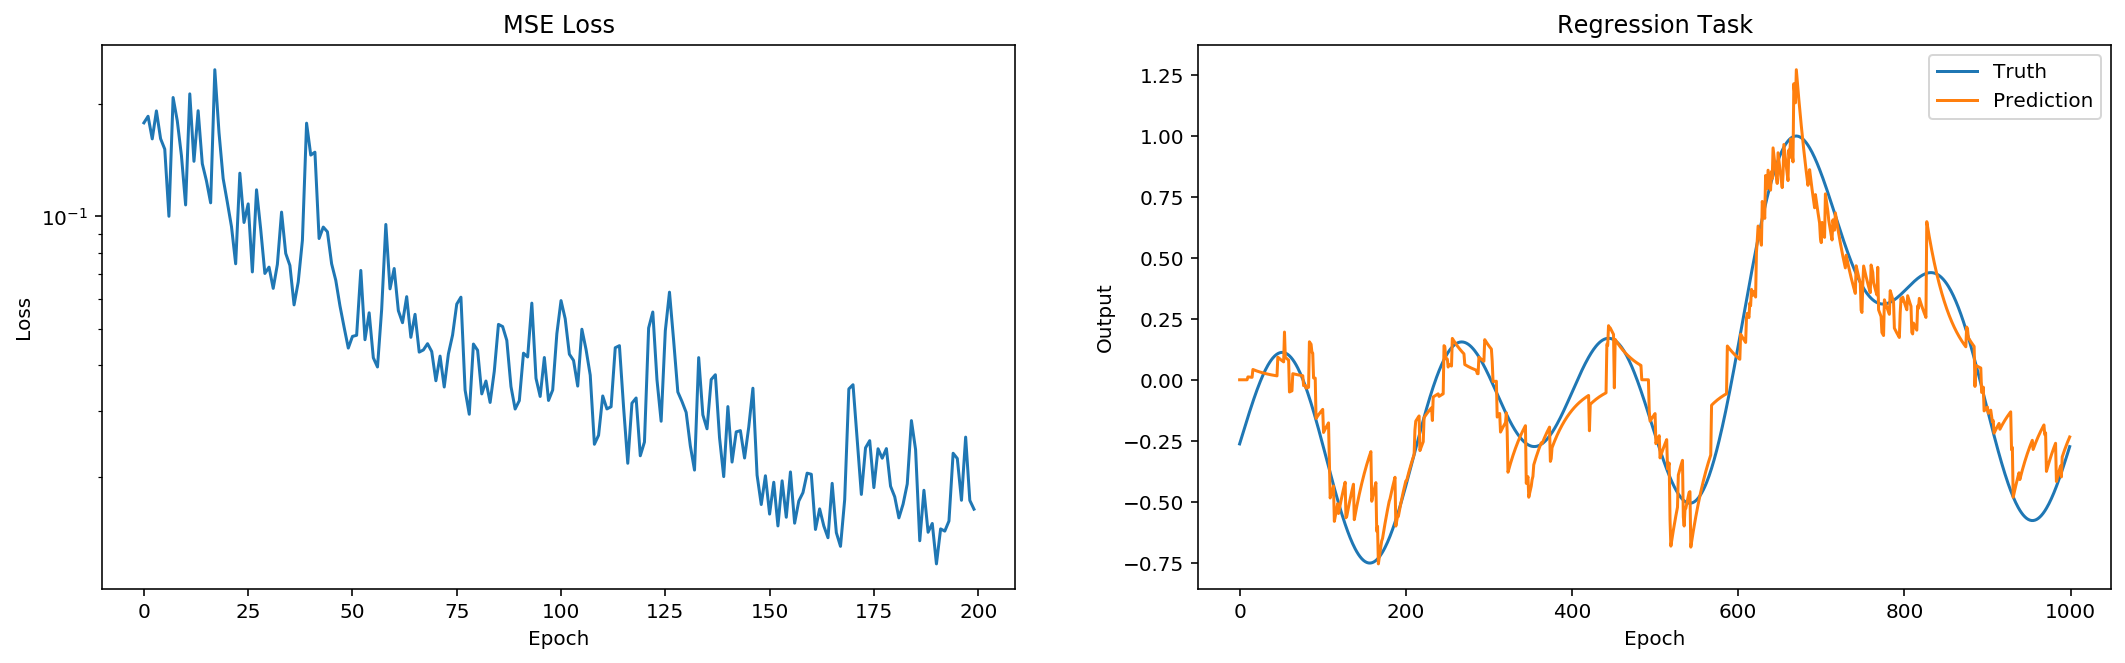

In [3]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.semilogy(loss_arr)
plt.subplot(122)
plt.title('Regression Task')
plt.xlabel('Epoch')
plt.ylabel('Output')
plt.plot(y, label='Truth')
plt.plot(yhat, label='Prediction')
plt.legend()